# Transfer Learning from an unsupervised semantic segmentation model using equivariance propreties

In [1]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision
from torchvision import models
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
from PIL import Image
from collections import Counter
from sklearn.metrics import jaccard_score
import pickle
from metric import *
from utils import * 
from scipy.ndimage.interpolation import rotate as scipy_rotate
from sklearn.metrics import jaccard_score
from sklearn.svm import LinearSVC




## Dataset : Pascal VOC 2012

In [2]:
dataroot = '/data/voc2012'
SAVE_DIR = '/data/model'


In [3]:
def change_type_input(img):
  return img.float()

def to_tensor_target(img):
  img = np.array(img)
  # border
  img[img==255] = 0 # border = background 
  return torch.LongTensor(img)

def padding(img,pad=(6,9)):
    return transforms.functional.pad(img, pad, fill=0, padding_mode='constant')

size = (513,513)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
transform_input = transforms.Compose([
                                   #transforms.Lambda(padding),
                                   transforms.Resize(size),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                    ])

transform_mask = transforms.Compose([
                                   #transforms.Lambda(padding),
                                   transforms.Resize(size),
                                   transforms.Lambda(to_tensor_target)
                                   ])


In [4]:
train_dataset = dset.VOCSegmentation(dataroot,year='2012', image_set='train', download=True,
                                     transform= transform_input,
                                     target_transform= transform_mask)

val_dataset = dset.VOCSegmentation(dataroot,year='2012', image_set='val', download=True,
                                     transform= transform_input,
                                     target_transform= transform_mask)

Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar


### Split dataset into a labeled dataset and a unlabeled dataset

In [5]:
class Split_Dataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

torch.manual_seed(0)    
percent = 0.3
split = int(len(train_dataset)*percent)
lengths = [split,len(train_dataset)-split]
labeled, unlabeled = random_split(train_dataset, lengths)
train_full_supervised = Split_Dataset(labeled)

torch.manual_seed(torch.initial_seed())

### Plot VOC image and mask

In [6]:
"""Pascal VOC Dataset Segmentation Dataloader"""


VOC_CLASSES = ('background',  # always index 0
               'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor')

NUM_CLASSES = len(VOC_CLASSES) + 1




In [7]:
print("Length dataset train fully supervised :",len(train_full_supervised))
print("Length dataset train unsupervised :",len(train_dataset))
print("Length dataset val :",len(val_dataset))

Length dataset train fully supervised : 439
Length dataset train unsupervised : 1464
Length dataset val : 1449


In [8]:
# Set batch_size
batch_size = 2

dataloader_train_supervised = torch.utils.data.DataLoader(train_full_supervised, batch_size=batch_size,drop_last=True)
dataloader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,drop_last=True)
# Decide which device we want to run on
device = torch.device("cuda")
print("device :",device)



device : cuda



## DeepLabV3 Pytorch

In [9]:
def load_model(file=None):
    if file is None:
        model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=False)
        model.to(device)
    else:
        model = torch.load(os.path.join(SAVE_DIR,file))
    return model

In [10]:
model = load_model('deeplabv3_unsupervised_voc.pt') # Load the DLV3 train on 30% of VOC2012
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## CNN classifier

In [11]:
class Classifier(torch.nn.Module):
    def __init__(self,):
        super(Classifier,self).__init__()
        self.conv1 = nn.Conv2d(21,21,kernel_size=(1,1),padding=0)
        
    def forward(self,x):
        y = self.conv1(x)
        return y

In [12]:
classif = Classifier()
classif.to(device)

Classifier(
  (conv1): Conv2d(21, 21, kernel_size=(1, 1), stride=(1, 1))
)

## Train classifier

In [13]:
save = os.path.join(SAVE_DIR,'cnn_classif_transfer_30_voc.pt')
learning_rate = 10e-4
moment = 0.9
optimizer = torch.optim.SGD(classif.parameters(),lr=learning_rate,weight_decay=2e-4,momentum=moment)
n_epochs = 20
#writer = SummaryWriter()
criterion = nn.CrossEntropyLoss(ignore_index=21) # On ignore la classe border.

In [14]:
iou_train = []
loss_train = []
iou_test = []
loss_test = []
all_loss = []
all_iou = []

In [15]:
for ep in range(n_epochs):

    for i,(x,mask) in enumerate(dataloader_train_supervised):
          x = x.to(device)
          mask = mask.to(device)
          model.eval()
          pred = model(x)
          pred = pred["out"]
          classif.train()
          pred_classif = classif(pred)
          loss = criterion(pred_classif,mask)
          all_loss.append(loss.item())
          loss.backward() 
          IoU = float(iou(pred_classif.argmax(dim=1),mask))
          all_iou.append(IoU)
          optimizer.step()
          optimizer.zero_grad()
    print('IoU :',IoU) 
    m_iou = np.array(all_iou).mean()
    m_loss = np.array(all_loss).mean()  
    loss_train.append(m_loss) 
    iou_train.append(m_iou)
    all_loss = []
    all_iou = []     

    print("EP:",ep," loss train:",m_loss," iou train:",m_iou)

    for i,(x,mask) in enumerate(dataloader_val):
          x = x.to(device)
          mask = mask.to(device)
          model.eval()
          with torch.no_grad():
            pred = model(x)
            pred = pred["out"]
          classif.eval()
          pred_classif = classif(pred)
          loss = criterion(pred_classif,mask)
          all_loss.append(loss.item())
          IoU = float(iou(pred_classif.argmax(dim=1).detach(),mask.detach()))
          all_iou.append(IoU)
            
    m_iou = np.array(all_iou).mean()
    m_loss = np.array(all_loss).mean()
    loss_test.append(m_loss)
    iou_test.append(m_iou)
    all_loss = []
    all_iou = []


    print("EP:",ep," loss test:",m_loss," iou test:",m_iou)


    torch.save(classif,save)

IoU : 6.695087192976068e-13
EP: 0  loss train: 2.6283240193101367  iou train: 0.02834486253420092
EP: 0  loss test: 2.0315354970278663  iou test: 1.9891544309811717e-11


/opt/conda/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Classifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


IoU : 6.695087192976068e-13
EP: 1  loss train: 1.6906514630470102  iou train: 1.505076393646416e-11
EP: 1  loss test: 1.4801067386378242  iou test: 1.9891544309811717e-11
IoU : 6.695087192976068e-13
EP: 2  loss train: 1.3830382807614052  iou train: 1.505076393646416e-11
EP: 2  loss test: 1.3455785188556375  iou test: 1.9891544309811717e-11
IoU : 6.695087192976068e-13
EP: 3  loss train: 1.3084763518479317  iou train: 1.505076393646416e-11
EP: 3  loss test: 1.3113291047883955  iou test: 1.9891544309811717e-11
IoU : 6.695087192976068e-13
EP: 4  loss train: 1.2871245009714065  iou train: 1.505076393646416e-11
EP: 4  loss test: 1.299805980937257  iou test: 1.9891544309811717e-11
IoU : 6.695087192976068e-13
EP: 5  loss train: 1.2787960268318925  iou train: 1.505076393646416e-11
EP: 5  loss test: 1.2942607256259708  iou test: 1.9891544309811717e-11
IoU : 6.695087192976068e-13
EP: 6  loss train: 1.2742233730886625  iou train: 1.505076393646416e-11
EP: 6  loss test: 1.2905408582799343  iou test

## Plot

Text(0, 0.5, 'Mean IOU')

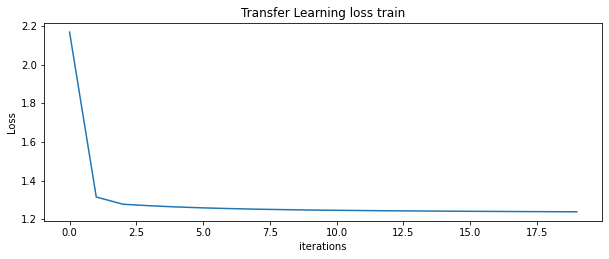

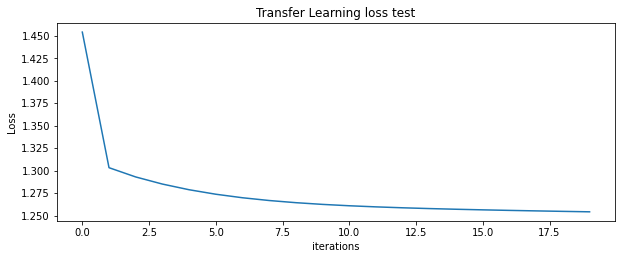

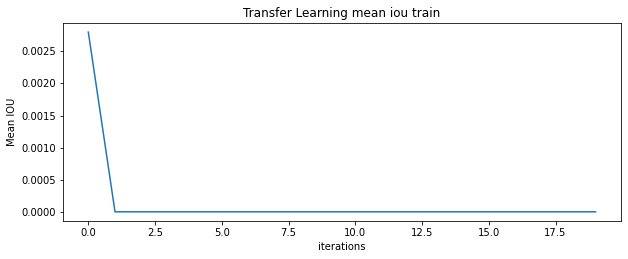

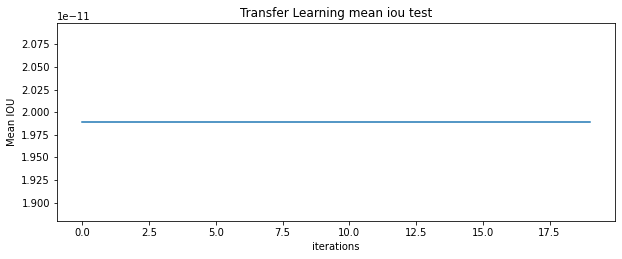

In [18]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("Transfer Learning loss train")
plt.plot(loss_train)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("Transfer Learning loss test")
plt.plot(loss_test)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("Transfer Learning mean iou train")
plt.plot(iou_train)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("Transfer Learning mean iou test")
plt.plot(iou_test)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")